# 🚶‍♂️오늘의 한 걸음 : Pix2Pix 로 도로이미지 생성하기

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 가져오기  
    2-2. 데이터 전처리  
        -1. real, segmentation
        -2. Augmentation
        
    2-3. 모델 학습  
        -1. Generator
        -2. Discriminator
        -3  학습
        
    2-4. 데이터 평가   

### 3. POTG
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  

---


## 1. Ready

### 1-1. 오늘의 Exp 와 Rubric

Gan 에 대해서 지금까지 많이 다뤄왔다.  

Gan (Generative Adverserial Net) 에서는  
Discriminator 모델과 Generator 모델이 서로 상호작용하며  
input 데이터와 비슷한 데이터를 만들어낸다.  

숫자 데이터인 Mnist 를 GAN 을 통해 학습시킨다면 출력값은 다음과 같다.

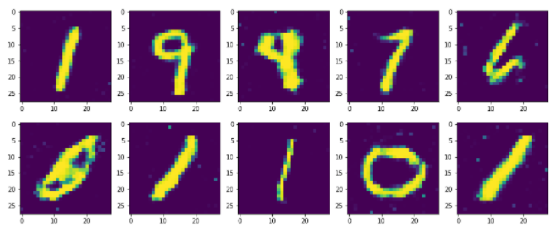

이에 한층 진화한 cGan 이 있다.  

cGan (conditional Gan) 은 Gan 에 특정 label, 즉 조건을 부여하여  
원하는 이미지를 뽑아낼 수 있다.

아래는 c=4 인 경우이다.
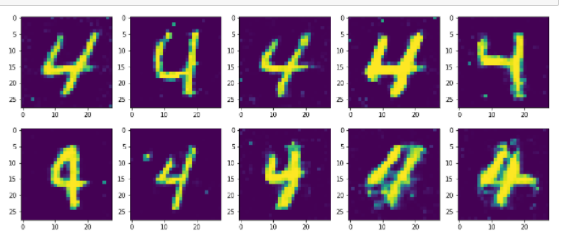

이 때, 조건을 부여하기 위해 label 이 아닌, 또 다른 이미지 데이터를 입력해줄 수 있다.  
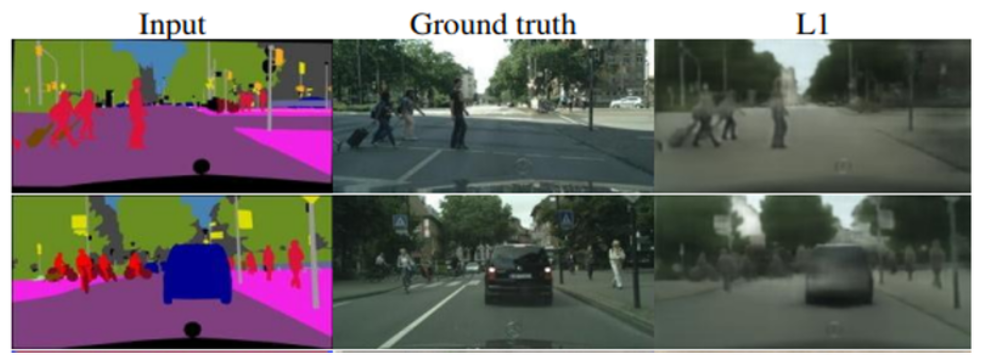

이러한 방법을 Pix2Pix 라고 한다.  

[Pix2Pix 논문 : image-to-image Translation with CAN](https://arxiv.org/pdf/1611.07004.pdf)

Pix2Pix 의 가장 큰 특징은 다음과 같다.

1. Conv layer 를 주로 사용한다.
2. encoder-decoder 구조이다.
3. 입력값을 유지하기 위해 U-Net 이라는 형태를 띠고 있다.

오늘은 위의 논문에서처럼 

도로 이미지, 도로 이미지의 segmentation 두 이미지를 이용해
새로운 도로 segmentation 만으로 새로운 도로 이미지를 만드는 Pix2Pix 모델을 만들 것이다. 

오늘의 rubric 은 다음과 같다.

|평가문항|상세기준|
|---|---|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

### 1-2. 사용하는 라이브러리

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2



In [21]:
import numpy
import tensorflow as tf

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


## 2. GAME
### 2-1. 데이터 가져오기

데이터는 tensorflow 에서 제공하고 있다.

In [4]:
data_path = os.getenv('HOME')+'/aiffel/workplace/E17/city/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


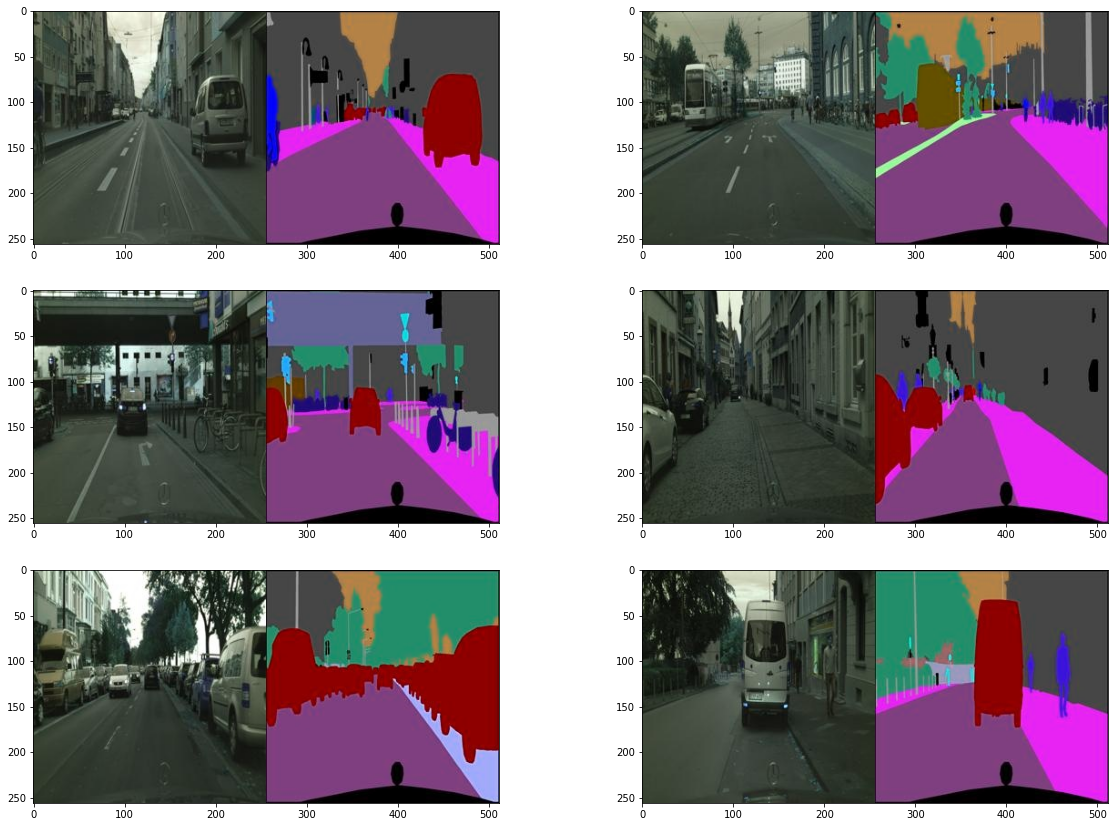

In [18]:

plt.figure(figsize=(20,30))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(6,2,i)
    plt.imshow(img)

이렇게 하나의 image data 에 segmentation 정보와 real 정보가 합쳐진 채로 들어가 있다.

test 데이터는 다음과 같다.

number of test examples : 1000


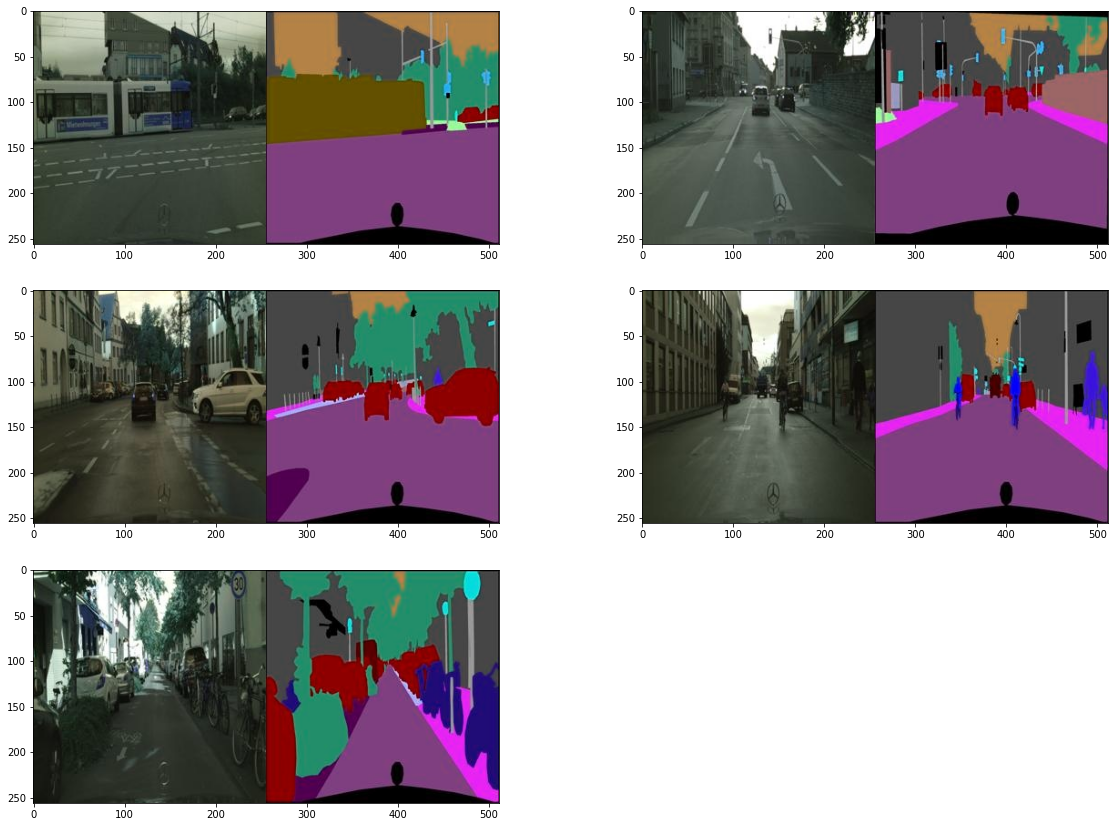

In [19]:
test_path = os.getenv('HOME')+'/aiffel/workplace/E17/city/cityscapes/val/'
print("number of test examples :", len(os.listdir(data_path)))


plt.figure(figsize=(20,30))
for i in range(1, 6):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(6,2,i)
    plt.imshow(img)

### 2-2. 데이터 전처리

In [20]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


말한 것처럼 세로 256, 가로 512 의 rgb 값임을 확인할 수 있다.  
segmentation 과 real 을 떼어놓기 위해 가로를 256 픽셀 기준으로 끊어 시각화한다.



### 2-2-1. real . segmentation 분리

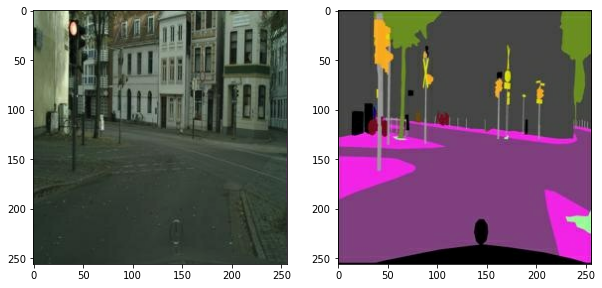

In [23]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real = img[:, :w, :] 
    real = tf.cast(real, tf.float32)
    segmentation = img[:, w:, :] 
    segmentation = tf.cast(segmentation, tf.float32)
    return normalize(real), normalize(segmentation)

f = data_path + os.listdir(data_path)[1]
real, segmentation = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(segmentation))

### 2-2-2. Augmentation

train 데이터를 증가시키기 위해 data augmentation 을 실시한다.

In [24]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

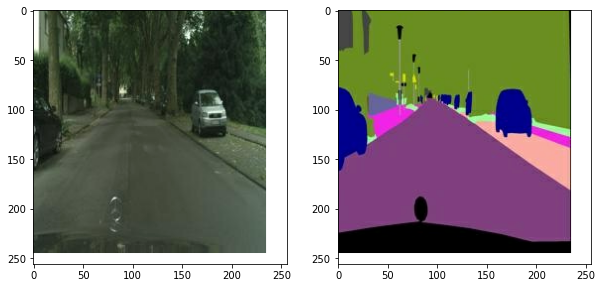

In [25]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### 2-3. 모델 학습 

### 2-3-1. Generator

In [26]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = [] #쓰일 block 값 지정 가능
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)): #출력데이터 요약
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [27]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [28]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


U-net 정의

In [29]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### 2-3-2 Discriminator

In [32]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [33]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
disc_block_5 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_8[0][0]        

loss 선정

In [34]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

Optimizer 선정

In [35]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


---
아래는 하나의 batch size 를 입력했을 때 가중치를 update 하는 코드이다.

In [36]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [37]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8465                     
L1_loss:0.3236                     
Discriminator_loss:1.1968

EPOCH[1] - STEP[20]                     
Generator_loss:0.9389                     
L1_loss:0.2908                     
Discriminator_loss:1.0129

EPOCH[1] - STEP[30]                     
Generator_loss:1.1749                     
L1_loss:0.2846                     
Discriminator_loss:1.0265

EPOCH[1] - STEP[40]                     
Generator_loss:1.3395                     
L1_loss:0.2548                     
Discriminator_loss:0.7811

EPOCH[1] - STEP[50]                     
Generator_loss:1.6739                     
L1_loss:0.2037                     
Discriminator_loss:0.5206

EPOCH[1] - STEP[60]                     
Generator_loss:1.2890                     
L1_loss:0.3065                     
Discriminator_loss:0.6337

EPOCH[1] - STEP[70]                     
Generator_loss:2.5720                     
L1_loss:0.2746                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.3799                     
L1_loss:0.2080                     
Discriminator_loss:0.5381

EPOCH[3] - STEP[80]                     
Generator_loss:2.9165                     
L1_loss:0.2247                     
Discriminator_loss:0.6421

EPOCH[3] - STEP[90]                     
Generator_loss:1.9075                     
L1_loss:0.1903                     
Discriminator_loss:0.3457

EPOCH[3] - STEP[100]                     
Generator_loss:1.8943                     
L1_loss:0.2012                     
Discriminator_loss:1.5057

EPOCH[3] - STEP[110]                     
Generator_loss:1.9626                     
L1_loss:0.1779                     
Discriminator_loss:0.9823

EPOCH[3] - STEP[120]                     
Generator_loss:2.3102                     
L1_loss:0.2112                     
Discriminator_loss:0.3388

EPOCH[3] - STEP[130]                     
Generator_loss:2.1651                     
L1_loss:0.1553                

EPOCH[5] - STEP[130]                     
Generator_loss:1.1598                     
L1_loss:0.1673                     
Discriminator_loss:1.0142

EPOCH[5] - STEP[140]                     
Generator_loss:2.1002                     
L1_loss:0.1774                     
Discriminator_loss:0.2878

EPOCH[5] - STEP[150]                     
Generator_loss:0.5016                     
L1_loss:0.2009                     
Discriminator_loss:1.3292

EPOCH[5] - STEP[160]                     
Generator_loss:2.8377                     
L1_loss:0.1857                     
Discriminator_loss:1.1080

EPOCH[5] - STEP[170]                     
Generator_loss:2.6417                     
L1_loss:0.1944                     
Discriminator_loss:0.8652

EPOCH[5] - STEP[180]                     
Generator_loss:3.2349                     
L1_loss:0.1729                     
Discriminator_loss:0.8131

EPOCH[5] - STEP[190]                     
Generator_loss:0.9126                     
L1_loss:0.1758             

EPOCH[7] - STEP[190]                     
Generator_loss:2.1593                     
L1_loss:0.1750                     
Discriminator_loss:1.0093

EPOCH[7] - STEP[200]                     
Generator_loss:1.6077                     
L1_loss:0.1592                     
Discriminator_loss:0.6132

EPOCH[7] - STEP[210]                     
Generator_loss:1.0056                     
L1_loss:0.1631                     
Discriminator_loss:0.7121

EPOCH[7] - STEP[220]                     
Generator_loss:3.1834                     
L1_loss:0.1663                     
Discriminator_loss:0.6613

EPOCH[7] - STEP[230]                     
Generator_loss:2.5831                     
L1_loss:0.2054                     
Discriminator_loss:0.4864

EPOCH[7] - STEP[240]                     
Generator_loss:0.8774                     
L1_loss:0.1803                     
Discriminator_loss:0.8537

EPOCH[7] - STEP[250]                     
Generator_loss:0.3010                     
L1_loss:0.1681             

EPOCH[9] - STEP[250]                     
Generator_loss:2.3843                     
L1_loss:0.1674                     
Discriminator_loss:0.3442

EPOCH[10] - STEP[10]                     
Generator_loss:1.7848                     
L1_loss:0.2031                     
Discriminator_loss:0.3245

EPOCH[10] - STEP[20]                     
Generator_loss:2.1091                     
L1_loss:0.2243                     
Discriminator_loss:0.2790

EPOCH[10] - STEP[30]                     
Generator_loss:0.9629                     
L1_loss:0.1471                     
Discriminator_loss:1.0793

EPOCH[10] - STEP[40]                     
Generator_loss:1.5169                     
L1_loss:0.1515                     
Discriminator_loss:0.8351

EPOCH[10] - STEP[50]                     
Generator_loss:0.6071                     
L1_loss:0.1810                     
Discriminator_loss:0.9907

EPOCH[10] - STEP[60]                     
Generator_loss:1.3555                     
L1_loss:0.1929             

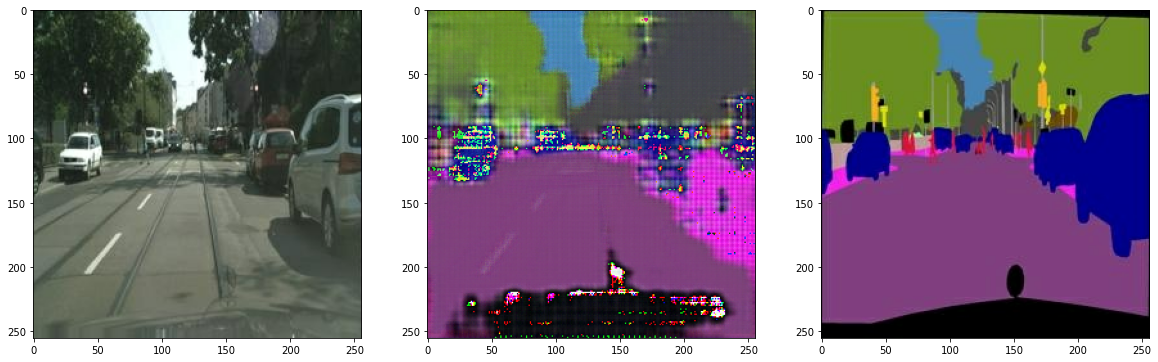

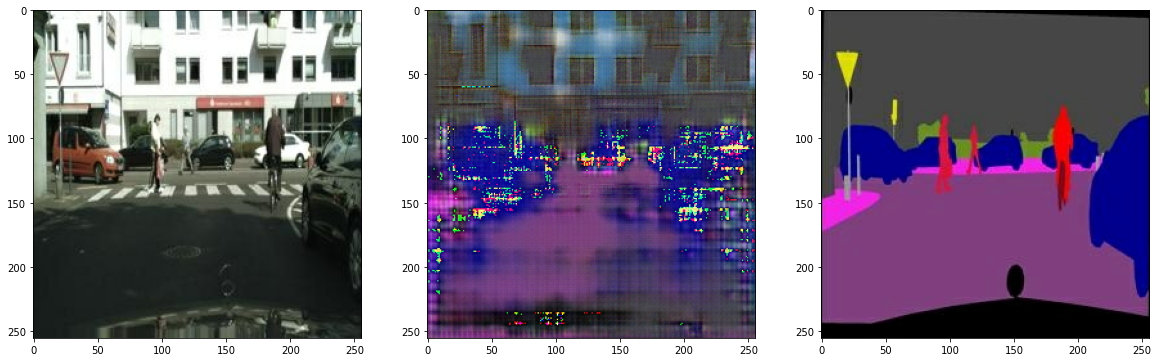

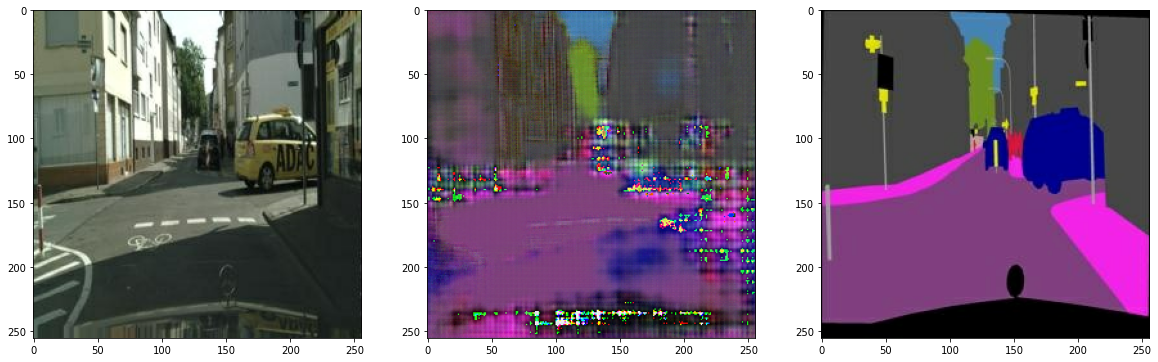

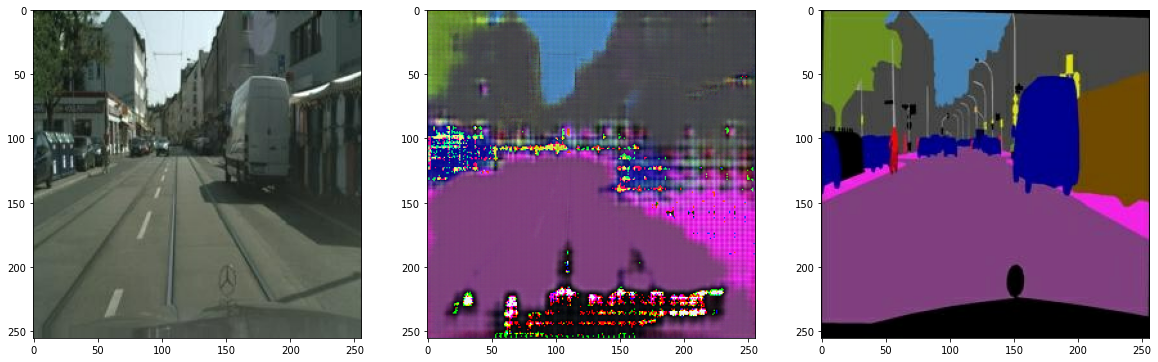

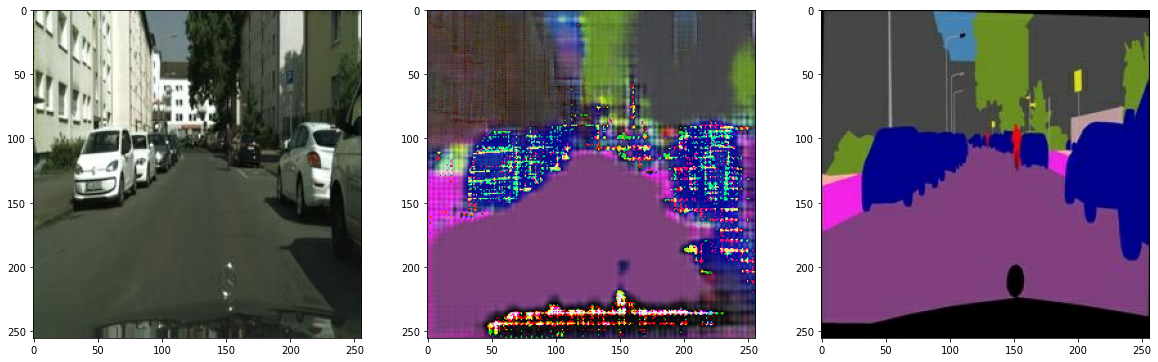

In [38]:
data_path=os.getenv('HOME')+'/aiffel/workplace/E17/city/cityscapes/val/'
num = len(os.listdir(data_path))

for test_ind in range(num):
    f = data_path + os.listdir(data_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [39]:
EPOCHS = 1

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.8612                     
L1_loss:0.1956                     
Discriminator_loss:0.7072

EPOCH[1] - STEP[20]                     
Generator_loss:2.3916                     
L1_loss:0.1760                     
Discriminator_loss:1.0269

EPOCH[1] - STEP[30]                     
Generator_loss:1.1882                     
L1_loss:0.1605                     
Discriminator_loss:0.8747

EPOCH[1] - STEP[40]                     
Generator_loss:0.6511                     
L1_loss:0.1767                     
Discriminator_loss:1.2002

EPOCH[1] - STEP[50]                     
Generator_loss:2.8739                     
L1_loss:0.2004                     
Discriminator_loss:0.9894

EPOCH[1] - STEP[60]                     
Generator_loss:1.7113                     
L1_loss:0.1723                     
Discriminator_loss:1.6300

EPOCH[1] - STEP[70]                     
Generator_loss:1.3056                     
L1_loss:0.1819                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.6368                     
L1_loss:0.1529                     
Discriminator_loss:1.1026

EPOCH[3] - STEP[80]                     
Generator_loss:2.0809                     
L1_loss:0.1569                     
Discriminator_loss:1.0159

EPOCH[3] - STEP[90]                     
Generator_loss:2.1973                     
L1_loss:0.1992                     
Discriminator_loss:0.2222

EPOCH[3] - STEP[100]                     
Generator_loss:2.6206                     
L1_loss:0.2088                     
Discriminator_loss:0.9029

EPOCH[3] - STEP[110]                     
Generator_loss:1.3465                     
L1_loss:0.1589                     
Discriminator_loss:0.5470

EPOCH[3] - STEP[120]                     
Generator_loss:2.3775                     
L1_loss:0.2116                     
Discriminator_loss:0.5939

EPOCH[3] - STEP[130]                     
Generator_loss:0.6189                     
L1_loss:0.1649                

EPOCH[5] - STEP[130]                     
Generator_loss:0.5146                     
L1_loss:0.1788                     
Discriminator_loss:1.4516

EPOCH[5] - STEP[140]                     
Generator_loss:1.7320                     
L1_loss:0.1703                     
Discriminator_loss:0.7069

EPOCH[5] - STEP[150]                     
Generator_loss:1.8573                     
L1_loss:0.1715                     
Discriminator_loss:0.7080

EPOCH[5] - STEP[160]                     
Generator_loss:3.2578                     
L1_loss:0.1490                     
Discriminator_loss:1.0847

EPOCH[5] - STEP[170]                     
Generator_loss:2.0343                     
L1_loss:0.2060                     
Discriminator_loss:0.3299

EPOCH[5] - STEP[180]                     
Generator_loss:2.6151                     
L1_loss:0.1508                     
Discriminator_loss:2.3353

EPOCH[5] - STEP[190]                     
Generator_loss:2.4640                     
L1_loss:0.1928             

EPOCH[7] - STEP[190]                     
Generator_loss:2.6385                     
L1_loss:0.1363                     
Discriminator_loss:0.5249

EPOCH[7] - STEP[200]                     
Generator_loss:3.3208                     
L1_loss:0.1440                     
Discriminator_loss:1.1642

EPOCH[7] - STEP[210]                     
Generator_loss:1.9055                     
L1_loss:0.2021                     
Discriminator_loss:0.2246

EPOCH[7] - STEP[220]                     
Generator_loss:2.6803                     
L1_loss:0.1873                     
Discriminator_loss:0.1895

EPOCH[7] - STEP[230]                     
Generator_loss:3.2268                     
L1_loss:0.1719                     
Discriminator_loss:0.1012

EPOCH[7] - STEP[240]                     
Generator_loss:3.1603                     
L1_loss:0.1438                     
Discriminator_loss:1.4938

EPOCH[7] - STEP[250]                     
Generator_loss:3.2524                     
L1_loss:0.1677             

EPOCH[9] - STEP[250]                     
Generator_loss:2.3378                     
L1_loss:0.1734                     
Discriminator_loss:0.1856

EPOCH[10] - STEP[10]                     
Generator_loss:2.3703                     
L1_loss:0.1623                     
Discriminator_loss:0.1829

EPOCH[10] - STEP[20]                     
Generator_loss:2.3726                     
L1_loss:0.1287                     
Discriminator_loss:0.6256

EPOCH[10] - STEP[30]                     
Generator_loss:0.9766                     
L1_loss:0.1535                     
Discriminator_loss:0.6919

EPOCH[10] - STEP[40]                     
Generator_loss:2.0406                     
L1_loss:0.1399                     
Discriminator_loss:0.9575

EPOCH[10] - STEP[50]                     
Generator_loss:1.3486                     
L1_loss:0.1893                     
Discriminator_loss:0.4834

EPOCH[10] - STEP[60]                     
Generator_loss:3.5909                     
L1_loss:0.1624             

EPOCH[12] - STEP[60]                     
Generator_loss:1.9107                     
L1_loss:0.1547                     
Discriminator_loss:0.2790

EPOCH[12] - STEP[70]                     
Generator_loss:2.4905                     
L1_loss:0.1527                     
Discriminator_loss:0.4218

EPOCH[12] - STEP[80]                     
Generator_loss:2.3891                     
L1_loss:0.1842                     
Discriminator_loss:0.2767

EPOCH[12] - STEP[90]                     
Generator_loss:1.9744                     
L1_loss:0.1598                     
Discriminator_loss:0.5659

EPOCH[12] - STEP[100]                     
Generator_loss:2.0805                     
L1_loss:0.1564                     
Discriminator_loss:0.3681

EPOCH[12] - STEP[110]                     
Generator_loss:3.5006                     
L1_loss:0.1325                     
Discriminator_loss:1.2430

EPOCH[12] - STEP[120]                     
Generator_loss:1.4519                     
L1_loss:0.1597          

EPOCH[14] - STEP[120]                     
Generator_loss:0.5603                     
L1_loss:0.2207                     
Discriminator_loss:1.1997

EPOCH[14] - STEP[130]                     
Generator_loss:1.2394                     
L1_loss:0.1612                     
Discriminator_loss:0.6463

EPOCH[14] - STEP[140]                     
Generator_loss:1.8660                     
L1_loss:0.1578                     
Discriminator_loss:0.7515

EPOCH[14] - STEP[150]                     
Generator_loss:1.8500                     
L1_loss:0.1562                     
Discriminator_loss:0.7799

EPOCH[14] - STEP[160]                     
Generator_loss:3.9629                     
L1_loss:0.1726                     
Discriminator_loss:0.4937

EPOCH[14] - STEP[170]                     
Generator_loss:2.9897                     
L1_loss:0.1427                     
Discriminator_loss:0.2065

EPOCH[14] - STEP[180]                     
Generator_loss:3.2226                     
L1_loss:0.1406      

EPOCH[16] - STEP[180]                     
Generator_loss:2.2593                     
L1_loss:0.1876                     
Discriminator_loss:0.3075

EPOCH[16] - STEP[190]                     
Generator_loss:3.6372                     
L1_loss:0.1383                     
Discriminator_loss:1.7793

EPOCH[16] - STEP[200]                     
Generator_loss:1.4883                     
L1_loss:0.1524                     
Discriminator_loss:0.3568

EPOCH[16] - STEP[210]                     
Generator_loss:2.0866                     
L1_loss:0.1618                     
Discriminator_loss:0.4446

EPOCH[16] - STEP[220]                     
Generator_loss:1.1978                     
L1_loss:0.1526                     
Discriminator_loss:0.5754

EPOCH[16] - STEP[230]                     
Generator_loss:2.5844                     
L1_loss:0.1509                     
Discriminator_loss:0.8623

EPOCH[16] - STEP[240]                     
Generator_loss:0.7253                     
L1_loss:0.1819      

EPOCH[18] - STEP[240]                     
Generator_loss:2.8727                     
L1_loss:0.1466                     
Discriminator_loss:1.1486

EPOCH[18] - STEP[250]                     
Generator_loss:1.3574                     
L1_loss:0.1592                     
Discriminator_loss:0.6766

EPOCH[19] - STEP[10]                     
Generator_loss:2.5691                     
L1_loss:0.1846                     
Discriminator_loss:0.2047

EPOCH[19] - STEP[20]                     
Generator_loss:1.0597                     
L1_loss:0.2050                     
Discriminator_loss:0.5731

EPOCH[19] - STEP[30]                     
Generator_loss:1.3057                     
L1_loss:0.1538                     
Discriminator_loss:0.6178

EPOCH[19] - STEP[40]                     
Generator_loss:2.7049                     
L1_loss:0.1285                     
Discriminator_loss:1.0660

EPOCH[19] - STEP[50]                     
Generator_loss:2.2979                     
L1_loss:0.1501           

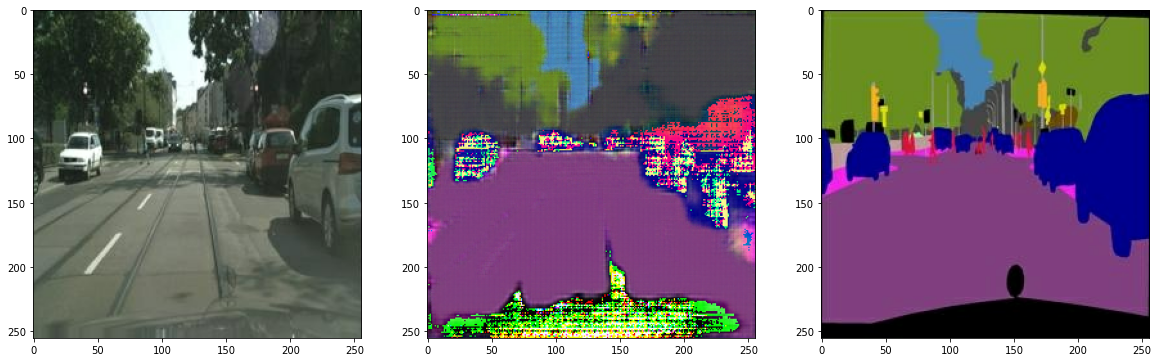

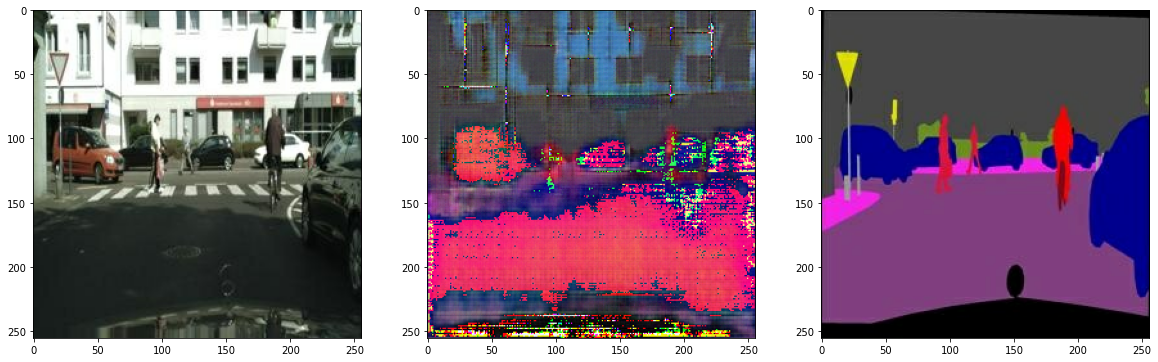

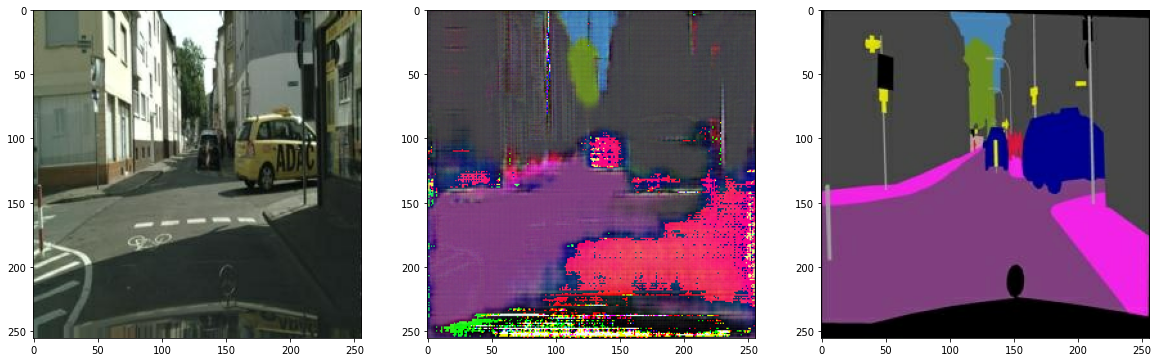

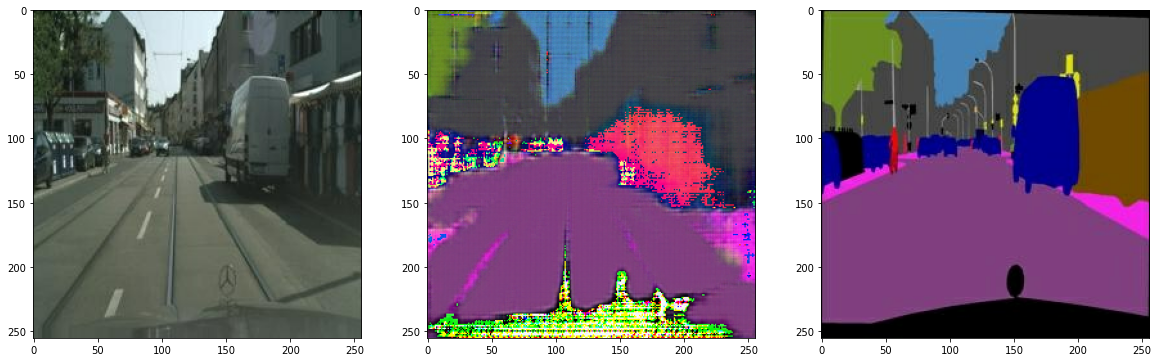

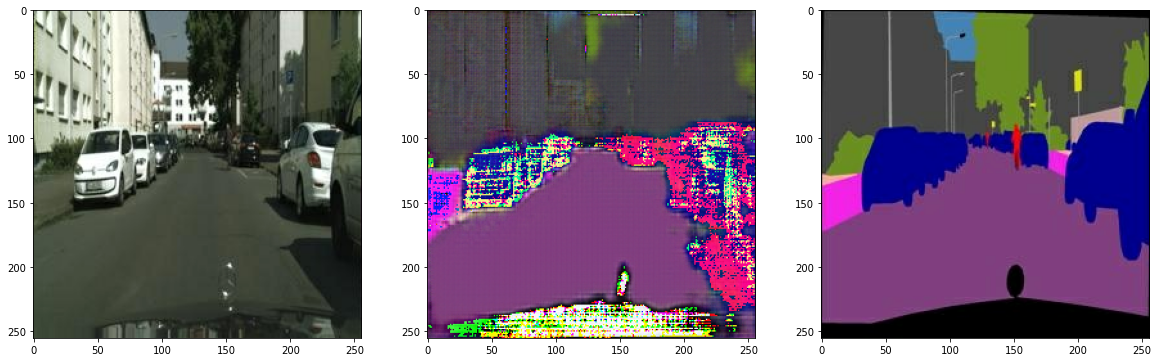

In [42]:
for test_ind in range(num):
    f = data_path + os.listdir(data_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

### 2-4. 데이터 평가   

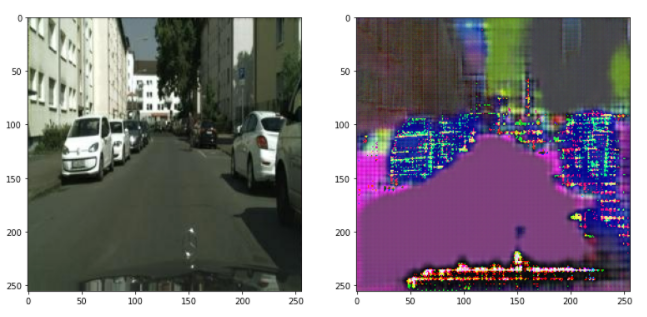

이것이 epoch 10 회의 모습이다.

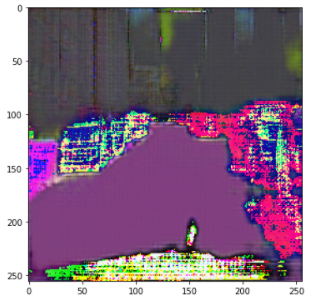

이것은 epoch 20 회의 모습이다.

확실히 epoch 이 오르며 배경 건물에 대한 경계선도 명확해지고  
차체의 경계선을 찾으려 노력하는 모습이 보인다.

## 3. POTG
### 3-1. 소감(POTG)  

#### "🖐 즐거웠어 Gan 아! 이제는 그만 만나자 !  "

Gan 에 encoder-decoder 학습방식을 가져왔다는 것이 신기했습니다. 이제는 NLP 분야로 더 공부할 예정인데, encoder-decoder 분야를 더 배워서 Cv 에 필요로 하는 사람이 있다면 꼭 잘 전수해드리고 싶습니다.

### 3-2. 어려웠던 점과 극복방안 

다행히 저번 수업 시간에 Gan 에 대해 상세히 배우고 짚고 넘어가  
생각보다는 쉽게 넘어갈 수 있었습니다.

cGAN 과 Pix2Pix 에서 바뀌는 사항들은 
맥락적인 요인들로는 이해할 수 있었습니다.  하지만 아직  

어떤 부분이 어떻게 다른지 구체적인 설명을 요구하면 자신이 없습니다.

기존 Gan 이  

G(z) 와 실제 데이터 x 를 판별하는 D(x, G(z)) 로 구성된다면,

cGan 은

G(z|y) 와 실제 데이터 x|y 룰 판별하는 D(x|y, G(z|y)) 입니다.

여기서 y는 라벨을 의미합니다.
z|y 는 y의 라벨을 가진 z 를 뜻합니다.

Pix2Pix 는

G(z|image) 와 실제 데이터 x|image 룰 판별하는 D(x|image, G(z|image)) 입니다.

이 기반을 잘 파악하고 있어야 합니다.
